# Bayesian Linear Regression

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import itertools
import functools
%matplotlib inline

np.random.seed(1234)

In [2]:
class PolynomialFeature(object):
    """
    polynomial features

    transforms input array with polynomial features

    Example
    =======
    x =
    [[a, b],
    [c, d]]

    y = PolynomialFeatures(degree=2).transform(x)
    y =
    [[1, a, b, a^2, a * b, b^2],
    [1, c, d, c^2, c * d, d^2]]
    """

    def __init__(self, degree=2):
        """
        construct polynomial features

        Parameters
        ----------
        degree : int
            degree of polynomial
        """
        assert isinstance(degree, int)
        self.degree = degree

    def transform(self, x):
        """
        transforms input array with polynomial features

        Parameters
        ----------
        x : (sample_size, n) ndarray
            input array

        Returns
        -------
        output : (sample_size, 1 + nC1 + ... + nCd) ndarray
            polynomial features
        """
        if x.ndim == 1:
            x = x[:, None]
        x_t = x.transpose()
        features = [np.ones(len(x))]
        for degree in range(1, self.degree + 1):
            for items in itertools.combinations_with_replacement(x_t, degree):
                features.append(functools.reduce(lambda x, y: x * y, items))
        return np.asarray(features).transpose()

In [3]:
class GaussianFeature(object):
    """
    Gaussian feature

    gaussian function = exp(-0.5 * (x - m) / v)
    """

    def __init__(self, mean, var):
        """
        construct gaussian features

        Parameters
        ----------
        mean : (n_features, ndim) or (n_features,) ndarray
            places to locate gaussian function at
        var : float
            variance of the gaussian function
        """
        if mean.ndim == 1:
            mean = mean[:, None]
        else:
            assert mean.ndim == 2
        assert isinstance(var, float) or isinstance(var, int)
        self.mean = mean
        self.var = var

    def _gauss(self, x, mean):
        return np.exp(-0.5 * np.sum(np.square(x - mean), axis=-1) / self.var)

    def transform(self, x):
        """
        transform input array with gaussian features

        Parameters
        ----------
        x : (sample_size, ndim) or (sample_size,)
            input array

        Returns
        -------
        output : (sample_size, n_features)
            gaussian features
        """
        if x.ndim == 1:
            x = x[:, None]
        else:
            assert x.ndim == 2
        assert np.size(x, 1) == np.size(self.mean, 1)
        basis = [np.ones(len(x))]
        for m in self.mean:
            basis.append(self._gauss(x, m))
        return np.asarray(basis).transpose()

In [4]:
class BayesianRegression():
    """
    Bayesian regression model

    w ~ N(w|0, alpha^(-1)I)
    y = X @ w
    t ~ N(t|X @ w, beta^(-1))
    """

    def __init__(self, alpha:float=1., beta:float=1.):
        self.alpha = alpha
        self.beta = beta
        self.w_mean = None
        self.w_precision = None

    def _is_prior_defined(self) -> bool:
        return self.w_mean is not None and self.w_precision is not None

    def _get_prior(self, ndim:int) -> tuple:
        if self._is_prior_defined():
            return self.w_mean, self.w_precision
        else:
            return np.zeros(ndim), self.alpha * np.eye(ndim)

    def fit(self, X:np.ndarray, t:np.ndarray):
        """
        bayesian update of parameters given training dataset

        Parameters
        ----------
        X : (N, n_features) np.ndarray
            training data independent variable
        t : (N,) np.ndarray
            training data dependent variable
        """

        mean_prev, precision_prev = self._get_prior(np.size(X, 1))

        w_precision = precision_prev + self.beta * X.T @ X
        w_mean = np.linalg.solve(
            w_precision,
            precision_prev @ mean_prev + self.beta * X.T @ t
        )
        self.w_mean = w_mean
        self.w_precision = w_precision
        self.w_cov = np.linalg.inv(self.w_precision)

    def predict(self, X:np.ndarray, return_std:bool=False, sample_size:int=None):
        """
        return mean (and standard deviation) of predictive distribution

        Parameters
        ----------
        X : (N, n_features) np.ndarray
            independent variable
        return_std : bool, optional
            flag to return standard deviation (the default is False)
        sample_size : int, optional
            number of samples to draw from the predictive distribution
            (the default is None, no sampling from the distribution)

        Returns
        -------
        y : (N,) np.ndarray
            mean of the predictive distribution
        y_std : (N,) np.ndarray
            standard deviation of the predictive distribution
        y_sample : (N, sample_size) np.ndarray
            samples from the predictive distribution
        """

        if sample_size is not None:
            w_sample = np.random.multivariate_normal(
                self.w_mean, self.w_cov, size=sample_size
            )
            y_sample = X @ w_sample.T
            return y_sample
        y = X @ self.w_mean
        if return_std:
            y_var = 1 / self.beta + np.sum(X @ self.w_cov * X, axis=1)
            y_std = np.sqrt(y_var)
            return y, y_std
        return y

In [5]:
def create_toy_data(func, sample_size, std, domain=[0, 1]):
    x = np.linspace(domain[0], domain[1], sample_size)
    np.random.shuffle(x)
    t = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, t

In [6]:
def sinusoidal(x):
    return np.sin(2 * np.pi * x)

## Closed-form solution for posterior

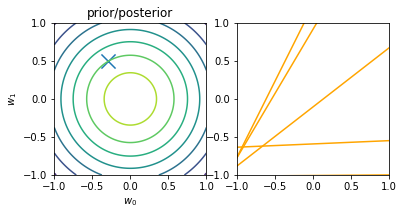

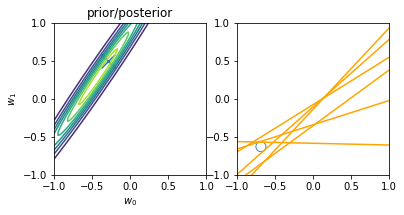

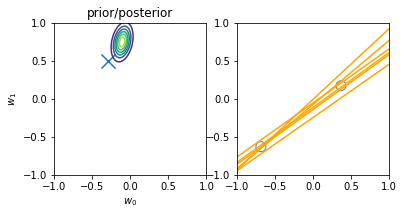

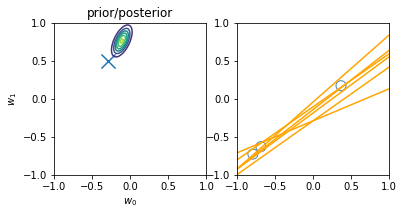

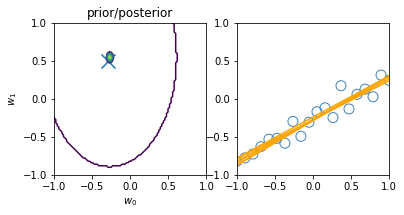

In [7]:
def linear(x):
    return -0.3 + 0.5 * x


x_train, y_train = create_toy_data(linear, 20, 0.1, [-1, 1])
x = np.linspace(-1, 1, 100)
w0, w1 = np.meshgrid(
    np.linspace(-1, 1, 100),
    np.linspace(-1, 1, 100))
w = np.array([w0, w1]).transpose(1, 2, 0)

feature = PolynomialFeature(degree=1)
X_train = feature.transform(x_train)
X = feature.transform(x)
model = BayesianRegression(alpha=1., beta=100.)

for begin, end in [[0, 0], [0, 1], [1, 2], [2, 3], [3, 20]]:
    model.fit(X_train[begin: end], y_train[begin: end])
    plt.subplot(1, 2, 1)
    plt.scatter(-0.3, 0.5, s=200, marker="x")
    plt.contour(w0, w1, multivariate_normal.pdf(w, mean=model.w_mean, cov=model.w_cov))
    plt.gca().set_aspect('equal')
    plt.xlabel("$w_0$")
    plt.ylabel("$w_1$")
    plt.title("prior/posterior")

    plt.subplot(1, 2, 2)
    plt.scatter(x_train[:end], y_train[:end], s=100, facecolor="none", edgecolor="steelblue", lw=1)
    plt.plot(x, model.predict(X, sample_size=6), c="orange")
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

## Predictive distribution

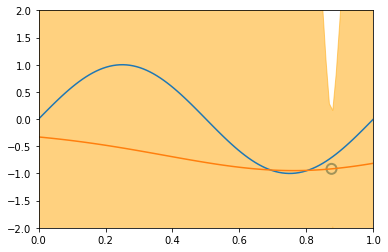

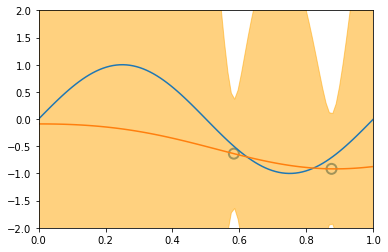

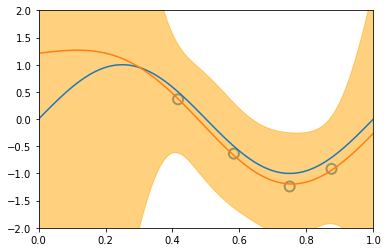

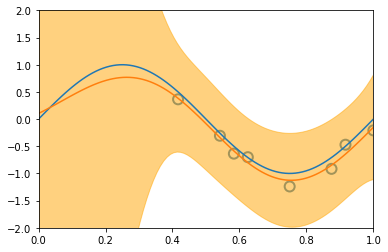

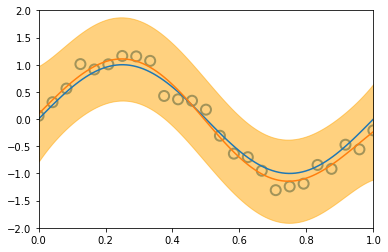

In [8]:
x_train, y_train = create_toy_data(sinusoidal, 25, 0.25)
x_test = np.linspace(0, 1, 100)
y_test = sinusoidal(x_test)

feature = GaussianFeature(np.linspace(0, 1, 9), 0.1)
X_train = feature.transform(x_train)
X_test = feature.transform(x_test)

model = BayesianRegression(alpha=1e-3, beta=2.)

for begin, end in [[0, 1], [1, 2], [2, 4], [4, 8], [8, 25]]:
    model.fit(X_train[begin: end], y_train[begin: end])
    y, y_std = model.predict(X_test, return_std=True)
    plt.scatter(x_train[:end], y_train[:end], s=100, facecolor="none", edgecolor="steelblue", lw=2)
    plt.plot(x_test, y_test)
    plt.plot(x_test, y)
    plt.fill_between(x_test, y - y_std, y + y_std, color="orange", alpha=0.5)
    plt.xlim(0, 1)
    plt.ylim(-2, 2)
    plt.show()